# Naive Classifier for Fake news recognition

## Packages

In [2]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)
library(parallel)

In [3]:
numCores <- detectCores()

# Reading the data

### Kaggle dataset

In [4]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [5]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

### Second dataset

# Display the train and test datasets

In [6]:
head(train.df)

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


In [7]:
head(test.df)

,Text,Text_Tag
,<chr>,<chr>
1,Building a wall on the U.S.-Mexico border will take literally years.,immigration
2,Wisconsin is on pace to double the number of layoffs this year.,jobs
3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"
6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement"


# Splitting the datasets

In [8]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [9]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [10]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [11]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

## Histogram of labels

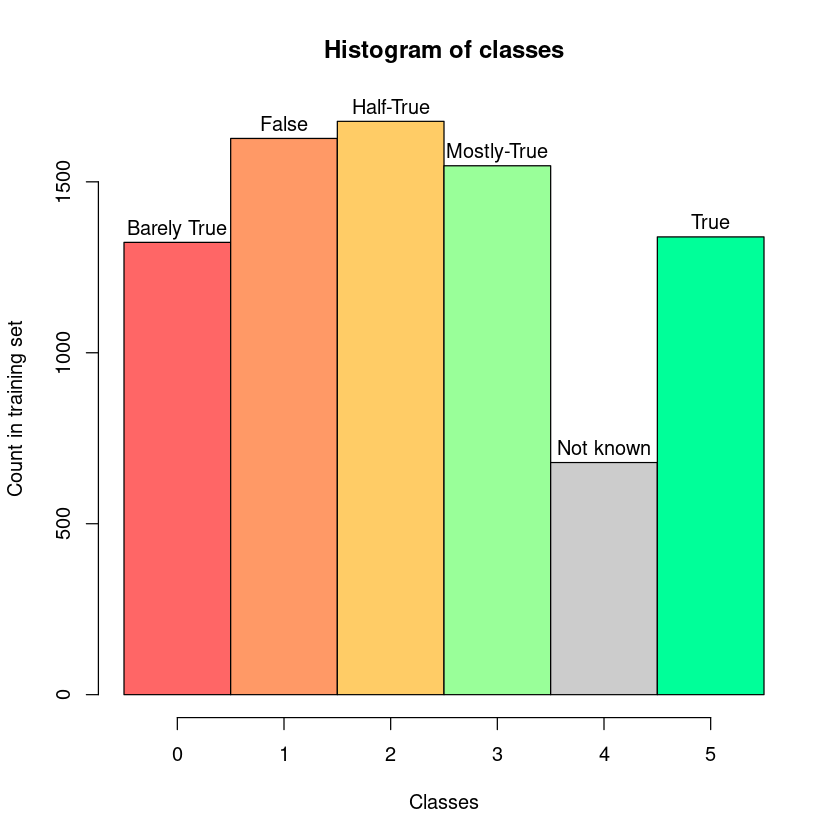

In [12]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

classes<-hist(x = train.df.train$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

In [13]:
n_classes <- length(labels)

## Defining the prior of each classes

In [14]:
prior.classes<-classes$density

## Stop words

In [15]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Cleaning function

In [16]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
    return(as.data.frame(word))
}

# Vocabulary

In [17]:
tags_numbers <- list(tags = c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True'),
                     numbers = c(0:5))

### Vocabulary before feature selection

In [18]:
vocabulary <- function(train.df.train, tags_numbers){
    #take in input a df with 'Text' column containing the messages and 'tag_numbers' the names of the labels
    
    myframes <- list()

    for (i in 1:length(tags_numbers$tags)) {
        tag <- tags_numbers$tags[i]

        train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
    } 
    counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')
    counts %<>% replace(is.na(.),0)
    return(counts)
}

# Feature Selection 

## Rankings

### Ranking per class
Ranks by a certain metric (df_rank) per class

In [19]:
ranking_per_class <- function(df_rank, counts, n_classes, frac) {
    mywords <- list()
    for (i in 2:(n_classes + 1)) {
        df_rank[, c(1, i)] %>%
            arrange(desc(.[[2]])) %>%
            top_frac(frac/n_classes, .[[2]]) %>%
            select(word) -> mywords[[i]]
    }
    words <- purrr::reduce(mywords, rbind)
    words %<>%
        unique

    counts %>%
        right_join(words["word"], by = join_by(word)) -> naive.bayes.vocabulary

    return(naive.bayes.vocabulary)
}

### Ranking by mean of classes
Ranks by a certain metric (df_rank) by mean

In [20]:
ranking_per_mean <- function(df_rank, counts, n_classes, frac) {
    df_rank["mean"] <- rowMeans(df_rank[2:(n_classes + 1)])

    df_rank %>%
        arrange(desc(mean)) %>%
        top_frac(frac, mean) %>%
        select(word) -> vocabulary.train.features

    counts %>%
        right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

    return(naive.bayes.vocabulary)
}

# Frequency

## Frequency by mean 

In [21]:
feature_selection.frequency_mean <- function(counts, n_classes, frac) {
    counts %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    counts_prob <- cbind(counts["word"], counts[2:(n_classes + 1)]/tot_counts_per_class)
    
    return(ranking_per_mean(counts_prob, counts, n_classes, frac))
}

## Frequency per class

In [22]:
feature_selection.frequency_per_class <- function(counts, n_classes, frac) {
    return(ranking_per_class(counts, counts, n_classes, frac))
}

# Chi squared

In [23]:
word_chi_squared <- function(word, train.df.train, n_classes) {
    if (word != "--number--") {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    } else {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    }

    chi <- vector(length = n_classes)
    for (i in 1:n_classes) {
        n11 <- as.numeric(yw_c[yw_c$Labels == (i - 1), ]$c)
        n10 <- as.numeric(sum(yw_c[yw_c$Labels != (i - 1), ]$c))
        n01 <- as.numeric(nw_c[yw_c$Labels == (i - 1), ]$c)
        n00 <- as.numeric(sum(nw_c[nw_c$Labels != (i - 1), ]$c))

        chi[i] <- ((n11 + n10 + n01 + n00) * (n11 * n00 - n10 * n01)^2)/((n11 + n01) *
            (n11 + n10) * (n10 + n00) * (n01 + n00))
    }
    chi[is.na(chi)] = 0

    return(chi)

}

In [24]:
vocabulary_chi_squared <- function(counts,  train.df.train, n_classes, numCores=numCores) {
    
    df <- mclapply(X = counts$word, FUN = word_chi_squared, train.df.train = train.df.train,
        n_classes = n_classes, mc.cores = numCores)

    chi <- cbind(counts[, 1], as.data.frame(do.call(rbind, df)))
    
    return(chi)
}

## Chi by mean

In [25]:
feature_selection.chi_squared_per_mean <- function(counts, train.df.train, n_classes,
    frac ) {

    chi<- vocabulary_chi_squared(counts, train.df.train, n_classes, numCores)

    return(ranking_per_mean(chi, counts, n_classes, frac))
}

## Chi by class

In [26]:
feature_selection.chi_squared_per_class <- function(counts, train.df.train, n_classes,
    frac) {

    chi <- vocabulary_chi_squared(counts, train.df.train, n_classes, numCores)

    return(ranking_per_class(chi, counts, n_classes, frac))
}

# Mutual information

## Mutual information per class

In [27]:
word_mutual_info <- function(word, train.df.train, n_classes) {
    if (word != "--number--") {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    } else {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    }

    MI <- vector(length = n_classes)
    for (i in 1:n_classes) {
        n11 <- as.numeric(yw_c[yw_c$Labels == (i - 1), ]$c)
        n10 <- as.numeric(sum(yw_c[yw_c$Labels != (i - 1), ]$c))
        n01 <- as.numeric(nw_c[yw_c$Labels == (i - 1), ]$c)
        n00 <- as.numeric(sum(nw_c[nw_c$Labels != (i - 1), ]$c))
        n1_ <- n11 + n10
        n0_ <- n01 + n00
        n_1 <- n01 + n11
        n_0 <- n10 + n00
        n <- n11 + n01 + n10 + n00
        MI[i] <- n11/n * log2(n * n11/(n1_ * n_1)) + n01/n * log2(n * n01/(n0_ *
            n_1)) + n10/n * log2(n * n10/(n1_ * n_0)) + n00/n * log2(n * n00/(n0_ *
            n_0))
    }
    MI[is.na(MI)] = 0

    return(MI)

}

In [28]:
vocabulary_mutual_info <- function(counts,  train.df.train, n_classes, numCores=numCores) {
    
    df <- mclapply(X = counts$word, FUN = word_mutual_info, train.df.train = train.df.train,
        n_classes = n_classes, mc.cores = numCores)

    mutual_info <- cbind(counts[, 1], as.data.frame(do.call(rbind, df)))
    
    return(mutual_info)
}

## Mutual by class

In [29]:
feature_selection.mutual_info_per_class <- function(counts, train.df.train, n_classes, frac) {

    mutual_info <- vocabulary_mutual_info(counts, train.df.train, n_classes, numCores)

    return(ranking_per_class(mutual_info, counts, n_classes, frac))
}

## Mutual by mean

In [30]:
feature_selection.mutual_info_per_mean <- function(counts, train.df.train, n_classes, frac) {

    mutual_info <- vocabulary_mutual_info(counts, train.df.train, n_classes, numCores)

    return(ranking_per_mean(mutual_info, counts, n_classes, frac))
}

# Likelihood computation

In [31]:
likelihood.denominator <- function(naive.bayes.vocabulary) {
    naive.bayes.vocabulary %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])
    return(den)
}

In [32]:
likelihood <- function(naive.bayes.vocabulary, den) {
    likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:(n_classes +
        1)] + 1)/den)
    return(likelihood.token)
}

## Nayve Bayes

In [33]:
tweet_tokenize <- function(msg) {
    tib <- data.frame(msg)
    colnames(tib) <- "tweet"
    tib %>%
        unnest_tokens(word, tweet) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens -> token.list
    return(token.list)
}

In [34]:
bayes.probability <- function(token.list, likelihood.token, prior.classes, den, n_classes) {

    query_out <- log(as.numeric(prior.classes))
    for (i in 1:length(token.list)) {
        query <- log(as.numeric(likelihood.token[likelihood.token["word"] == token.list$word[i]][2:(n_classes +
            1)]))
        if (is.na(query[1])) {
            # because if the word is not found, all NA are returned. if the
            # word is in the vocabulary the proper likelihood is returned
            query <- as.numeric(log(1/den))
        }
        query_out <- query_out + query
    }
    query_out <- exp(query_out)
    query_out <- query_out/sum(query_out)
    return(query_out)
}

In [35]:
naive.bayes <- function(msg, likelihood.token, prior.classes, den, n_classes) {
    token.list <- as.vector(tweet_tokenize(msg))
    probability <- bayes.probability(token.list, likelihood.token, prior.classes,
        den, n_classes)
    predicted_class <- which.max(probability) - 1
    return(predicted_class)
}

# Training: creating and saving the dfs with words and countings according to feature selection method

In [36]:
fraction<-seq(from =0.1, to =1, by=0.2)

In [37]:
# Return data.frame with only counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

In [38]:
for (i in seq_along(fraction)) {
    write.csv(feature_selection.frequency_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models4/frequency_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.frequency_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models4/frequency_per_mean", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.chi_squared_per_class(counts, train.df.train, n_classes, frac = fraction[i]),
        file = paste("models4/chi_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.chi_squared_per_mean(counts, train.df.train, n_classes, frac = fraction[i]),
        file = paste("models4/chi_per_mean", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.mutual_info_per_class(counts, train.df.train, n_classes, frac = fraction[i]),
        file = paste("models4/mutual_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.mutual_info_per_mean(counts, train.df.train, n_classes, frac = fraction[i]),
        file = paste("models4/mutual_per_mean", fraction[i], ".csv", sep = ""))
}

# Apply to the validation set and plot accuarcies for different methods

In [39]:
file_list <- c(list.files(path = "models4", pattern = "frequency_per_mean*"),
               list.files(path = "models4", pattern = "frequency_per_class*"),
               list.files(path = "models4", pattern = "chi_per_mean*"),
               list.files(path = "models4", pattern = "chi_per_class*"),
               list.files(path = "models4", pattern = "mutual_per_class*"),
               list.files(path = "models4", pattern = "mutual_per_mean*"))

In [40]:
file_list

[1] "frequency_per_mean0.1.csv"  "frequency_per_mean0.3.csv" 
 [3] "frequency_per_mean0.5.csv"  "frequency_per_mean0.7.csv" 
 [5] "frequency_per_mean0.9.csv"  "frequency_per_class0.1.csv"
 [7] "frequency_per_class0.3.csv" "frequency_per_class0.5.csv"
 [9] "frequency_per_class0.7.csv" "frequency_per_class0.9.csv"
[11] "chi_per_mean0.1.csv"        "chi_per_mean0.3.csv"       
[13] "chi_per_mean0.5.csv"        "chi_per_mean0.7.csv"       
[15] "chi_per_mean0.9.csv"        "chi_per_class0.1.csv"      
[17] "chi_per_class0.3.csv"       "chi_per_class0.5.csv"      
[19] "chi_per_class0.7.csv"       "chi_per_class0.9.csv"      
[21] "mutual_per_class0.1.csv"    "mutual_per_class0.3.csv"   
[23] "mutual_per_class0.5.csv"    "mutual_per_class0.7.csv"   
[25] "mutual_per_class0.9.csv"    "mutual_per_mean0.1.csv"    
[27] "mutual_per_mean0.3.csv"     "mutual_per_mean0.5.csv"    
[29] "mutual_per_mean0.7.csv"     "mutual_per_mean0.9.csv"

In [42]:
acc<-vector()
for (i in seq_along(file_list)) {

    naive.bayes.vocabulary <- read.csv(paste("./models4", file_list[i], sep = "/")) %>%
        select(-X)
    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes, mc.cores = numCores)

    # Check % of right predictions
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}

In [43]:
acc_matrix <- matrix(acc, byrow=TRUE, ncol=5)

In [85]:
png(file = 'accuracy/feature_selection_accuracy.png')

options(repr.plot.width = 10, repr.plot.height=8)

colors <- c('#FE218B', '#FE218B', '#FED700', '#FED700', '#21B0FE', '#21B0FE')
pch <- c(15, 17, 15,17, 15, 17)

plot(fraction, acc_matrix[1,], ylim=c(0.18, 0.25), col=colors[1],
     xlab='Fraction retained', ylab='Accuracy', pch=pch[1], cex=1.5, cex.lab=1.5)
lines(fraction, acc_matrix[1,], col=colors[1])
grid()
for (i in 2:6){
    points(fraction, acc_matrix[i,], col=colors[i], pch=pch[i], cex=1.5)
    lines(fraction, acc_matrix[i,], col=colors[i])
}
legend(0.1,0.25, legend=c('frequency per mean', 'frequency per class',
                           'chi2 per mean', 'chi2 per class', 'MI per mean', 
                           'MI per class'), col=colors, pch=pch, cex=1.2 )

dev.off()

png 
  2

In [45]:
acc_matrix

0.2153320,0.2192383,0.2187500,0.2221680,0.2114258
0.2167969,0.2080078,0.2089844,0.2158203,0.2114258
0.1962891,0.1884766,0.2114258,0.2055664,0.1972656
0.2041016,0.1997070,0.1977539,0.2016602,0.1972656
0.2016602,0.2128906,0.1977539,0.2036133,0.2138672
0.2084961,0.1967773,0.2172852,0.2031250,0.2031250


In [46]:
write.csv(acc_matrix, file = "accuracy/models4.csv")